# Goal

* Exploring potential methods of comparing HR-SIP gradient data (compositional data) that reflects differences in peak height/width/location in eudlidean space (absolute abundances)

# Init

In [35]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [36]:
%%R
library(dplyr)
library(tidyr)
library(ggplot2)
library(compositions)
library(coenocliner)
library(vegan)
library(gridExtra)

options(scipen=999)

# Creating test communities

* varying parameters:
  * peak locations (species optima)
  * peak widths (species tolerances)
  * peak heights (max abundances)

## Varying peak locations

In [54]:
%%R 
set.seed(2)
M = 1000                                   # number of species
ming = 1.67323                             # gradient minimum...
maxg = 1.76                                # ...and maximum
#meang = mean(c(ming, maxg))
meang = 1.71
locs = seq(ming, maxg, length = 24)        # gradient locations
opt  = rnorm(M, mean=meang, sd=0.005)          # runif(M, min = ming, max = maxg)   # species optima
tol  = rep(0.005, M)                       # species tolerances
h    = ceiling(rlnorm(M, meanlog = 11))    # max abundances
pars = cbind(opt = opt, tol = tol, h = h)  # put in a matrix

# Pairwise of parameters

In [55]:
%%R
W = c(0.0005, 0.001, 0.005, 0.01)
L = c(0.001, 0.005, 0.01, 0.05)

In [56]:
%%R
# making communities
make_comm = function(x, MM, meang, h, locs){
    W = x[1] %>% as.numeric
    L = x[2] %>% as.numeric
    tol  = rep(W, MM)      
    opt  = rnorm(MM, mean=meang, sd=L)
    pars = cbind(opt = opt, tol = tol, h = h) 
    coenocline(locs, responseModel = "gaussian", params = pars, countModel = "poisson") 
    }

params = expand.grid(W, L) 

df = list()
for (i in 1:nrow(params)){
    name = paste(params[i,], collapse='__')
    tmp = make_comm(params[i,], MM=M, meang=meang, h=h, locs=locs) %>% t
    colnames(tmp) = locs
    df[[name]] = tmp %>% as.data.frame
    }
df = do.call(rbind, df)

df[1:5,1:10]

                1.67323 1.67700260869565 1.6807752173913 1.68454782608696
0.0005__0.001.1       0                0               0                0
0.0005__0.001.2       0                0               0                0
0.0005__0.001.3       0                0               0                0
0.0005__0.001.4       0                0               0                0
0.0005__0.001.5       0                0               0                0
                1.68832043478261 1.69209304347826 1.69586565217391
0.0005__0.001.1                0                0                0
0.0005__0.001.2                0                0                0
0.0005__0.001.3                0                0                0
0.0005__0.001.4                0                0                0
0.0005__0.001.5                0                0                0
                1.69963826086957 1.70341086956522 1.70718347826087
0.0005__0.001.1                0                0            17311
0.0005__0.001.2     

In [57]:
%%R
# formatting table
df$taxon = gsub('.+\\.', '', rownames(df))
df$params = gsub('\\.[0-9]+$', '', rownames(df))
df = df %>%
    gather(BD, count, 1:(ncol(.)-2)) %>%
    separate(params, c('W', 'L'), sep='__') %>%
    group_by(W, L) %>%
    mutate(fraction = BD %>% as.factor %>% as.numeric) %>%
    ungroup() %>%
    mutate(BD = BD %>% as.character %>% as.numeric,
           W = W %>% as.character %>% as.numeric,
           L = L %>% as.character %>% as.numeric,
           count = count %>% as.character %>% as.numeric) %>%
    group_by(fraction, W, L) %>%
    mutate(rel_abund = count / sum(count),
           rel_abund = ifelse(is.na(rel_abund), 0, rel_abund)) %>%
    ungroup()

df %>% head(n=3)

Source: local data frame [3 x 7]

  taxon      W     L      BD count fraction rel_abund
  (chr)  (dbl) (dbl)   (dbl) (dbl)    (dbl)     (dbl)
1     1 0.0005 0.001 1.67323     0        1         0
2     2 0.0005 0.001 1.67323     0        1         0
3     3 0.0005 0.001 1.67323     0        1         0


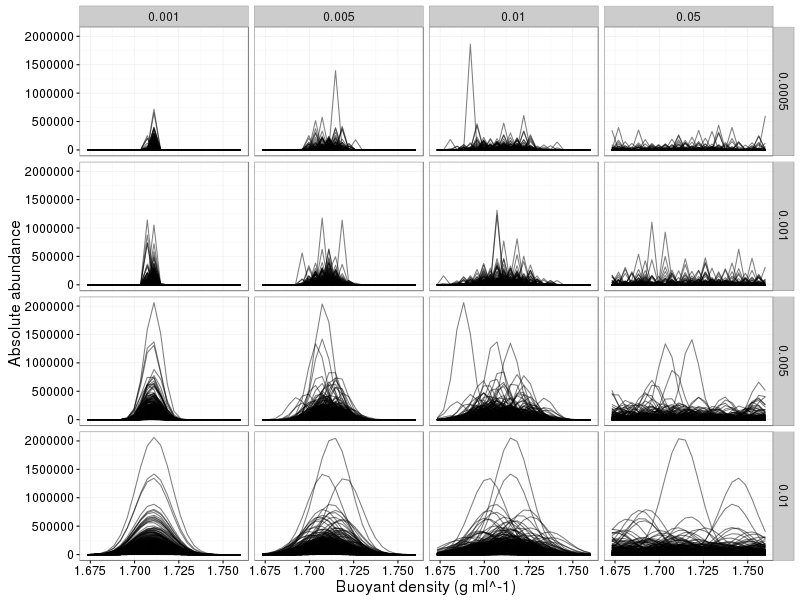

In [58]:
%%R -w 800 -h 600

ggplot(df, aes(BD, count, group=taxon)) +
    geom_line(alpha=0.5) +
    facet_grid(W ~ L) +
    labs(x='Buoyant density (g ml^-1)', y='Absolute abundance') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

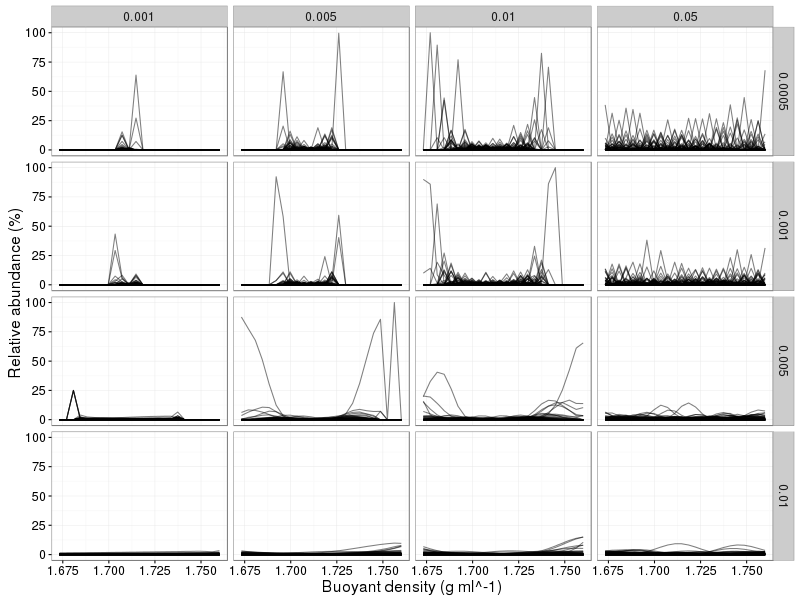

In [59]:
%%R -w 800 -h 600

ggplot(df, aes(BD, rel_abund * 100, group=taxon)) +
    geom_line(alpha=0.5) +
    facet_grid(W ~ L) +
    labs(x='Buoyant density (g ml^-1)', y='Relative abundance (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Comparing communities

### Asigning zeros

In [60]:
%%R
# giving value to missing abundances
min.pos.val = df %>%
    filter(rel_abund > 0) %>%
    group_by() %>%
    mutate(min_abund = min(rel_abund)) %>%
    ungroup() %>%
    filter(rel_abund == min_abund)

min.pos.val = min.pos.val[1,'rel_abund'] %>% as.numeric
imp.val = min.pos.val / 10


# convert numbers
#df[df$rel_abund == 0, 'rel_abund'] = imp.val

# another closure operation
df = df %>%
    mutate(rel_abund = ifelse(rel_abund == 0, imp.val, rel_abund)) %>%
    group_by(fraction, W, L) %>%
    mutate(rel_abund = rel_abund / sum(rel_abund))

# status
cat('Below detection level abundances converted to: ', imp.val, '\n')

Below detection level abundances converted to:  0.000000001620636 


## Shannon diversity

In [61]:
%%R
shannon_index_long = function(df, abundance_col, ...){
    # calculating shannon diversity index from a 'long' formated table
    ## community_col = name of column defining communities
    ## abundance_col = name of column defining taxon abundances
    df = df %>% as.data.frame
    cmd = paste0(abundance_col, '/sum(', abundance_col, ')')
    df.s = df %>%
        group_by_(...) %>%
        mutate_(REL_abundance = cmd) %>%
        mutate(pi__ln_pi = REL_abundance * log(REL_abundance),
               shannon = -sum(pi__ln_pi, na.rm=TRUE)) %>%
        ungroup() %>% 
        dplyr::select(-REL_abundance, -pi__ln_pi) %>%
        distinct_(...) 
    return(df.s)
}

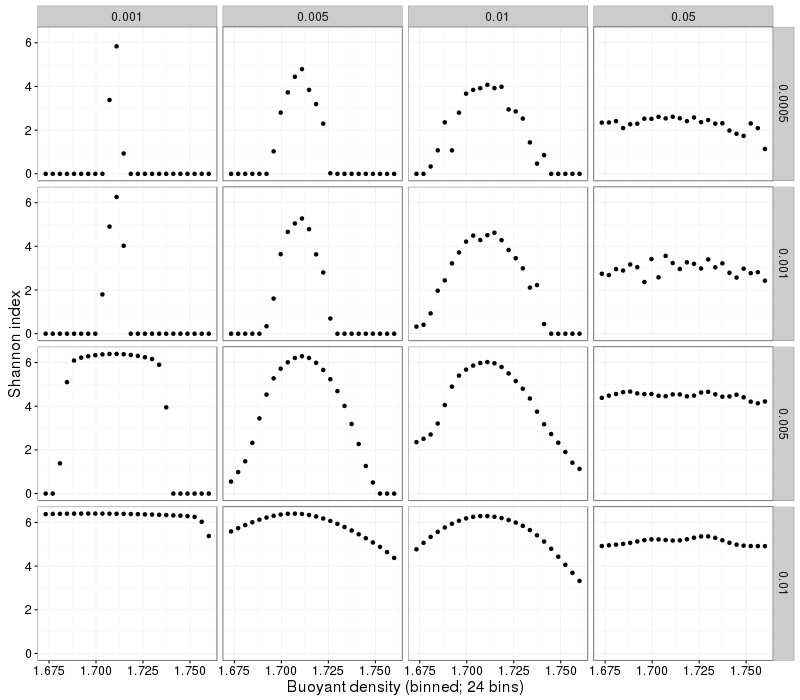

In [62]:
%%R -w 800 -h 700
# calculating shannon
df.shan = shannon_index_long(df, 'count', 'fraction', 'BD', 'W', 'L')


# summarizing
df.shan.s = df.shan %>%
    group_by(W, L, BD_bin = ntile(BD, 24)) %>%
    summarize(mean_shannon = mean(shannon, na.rm=TRUE), 
              sd_shannon = sd(shannon, na.rm=TRUE), 
              mean_BD = mean(BD, na.rm=TRUE)) %>%
    ungroup %>%
    mutate(sd_shannon = ifelse(is.na(sd_shannon), 0, sd_shannon))


# plotting
p = ggplot(df.shan.s, aes(mean_BD, mean_shannon, 
                          ymin=mean_shannon-sd_shannon,
                          ymax=mean_shannon+sd_shannon)) +
    geom_pointrange(size=0.2) +
    labs(x='Buoyant density (binned; 24 bins)', y='Shannon index') +
    facet_grid(W ~ L) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

In [63]:
%%R -w 650 -h 600
# pairwise correlations for each dataset
df.shan.bin = df.shan %>%
    group_by(BD_bin = ntile(BD, 24)) 

calc.pearson = function(x){
    cor(x[,'shannon.x'], x['shannon.y'], method='pearson')[1,1]
}

 

df.shan.corr = inner_join(df.shan.bin, df.shan.bin, c('BD_bin' = 'BD_bin',
                                                      'W' = 'W',
                                                      'L' = 'L')) %>%
    group_by(W, L) %>%
    nest() %>%
    mutate(model = purrr::map(data, calc.pearson)) %>%
    unnest(pearson = model %>% purrr::map(function(x) x)) %>%
    ungroup() %>%
    select(-data, -model) %>%
    mutate(pearson_txt = round(pearson, 2))
        
df.shan.corr %>% head        

Source: local data frame [6 x 4]

       W     L pearson pearson_txt
   (dbl) (dbl)   (dbl)       (dbl)
1 0.0005 0.001       1           1
2 0.0010 0.001       1           1
3 0.0050 0.001       1           1
4 0.0100 0.001       1           1
5 0.0005 0.005       1           1
6 0.0010 0.005       1           1


In [64]:
%%R
options(scipen=999)
1e5  %>% as.vector %>% as.character

[1] "100000"


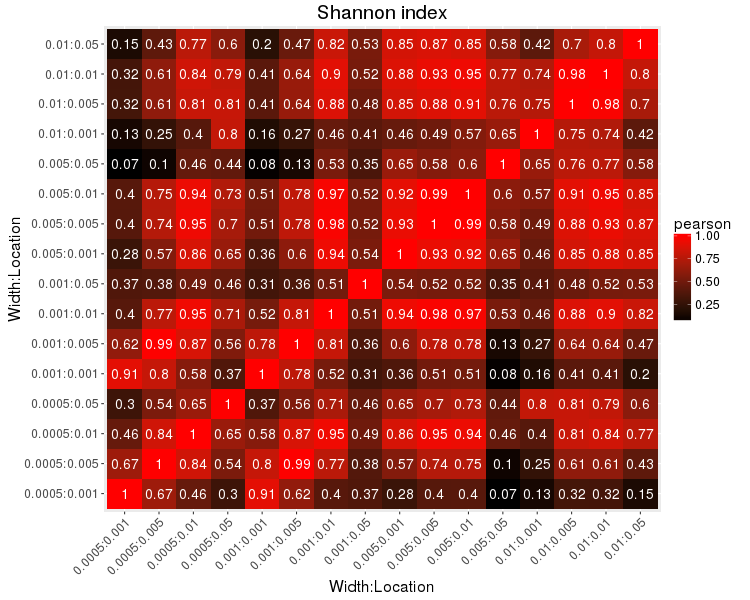

In [65]:
%%R -w 750 -h 600
# pairwise correlations for each dataset
df.shan.bin = df.shan %>%
    group_by(BD_bin = ntile(BD, 24)) %>%
    unite(dataset, W, L, sep=':', remove=FALSE)


calc.pearson = function(x){
    cor(x[,'shannon.x'], x['shannon.y'], method='pearson')[1,1]
}
as.num = function(x) x %>% as.character %>% as.numeric
 

df.shan.corr = inner_join(df.shan.bin, df.shan.bin, c('BD_bin' = 'BD_bin')) %>%
    group_by(dataset.x, dataset.y) %>%
    nest() %>%
    mutate(model = purrr::map(data, calc.pearson)) %>%
    unnest(pearson = model %>% purrr::map(function(x) x)) %>%
    ungroup() %>%
    select(-data, -model) %>%
    mutate(pearson_txt = round(pearson, 2))

        
 # plotting
lab = 'Width:Location'  
ggplot(df.shan.corr, aes(dataset.x, dataset.y, fill=pearson)) +
    geom_tile() +
    geom_text(aes(label=pearson_txt), color='white', size=5) +
    scale_fill_gradient(low='black', high='red') +
    labs(x=lab, y=lab, title='Shannon index') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    ) 

# Correlograms

In [66]:
%%R

BD.diffs = function(df){
    BDs = df$BD %>% unique
    df.BD = expand.grid(BDs, BDs)
    df.BD$diff = df.BD %>% apply(1, diff) %>% abs %>% as.vector    
    df.BD = df.BD %>% spread(Var1, diff) 
    rownames(df.BD) = df.BD$Var2
    df.BD$Var2 = NULL
    dist.BD = df.BD %>% as.matrix
    dist.BD[upper.tri(dist.BD, diag=TRUE)] = 0
    dist.BD %>% as.dist
    }

vegdist.by = function(df, ...){
    df.w = df %>%
        select(taxon, rel_abund, fraction, BD) %>%
        spread(taxon, rel_abund) %>%
        as.data.frame()
    
    rownames(df.w) = df.w$BD %>% as.vector
    df.w$BD = NULL
    df.w$fraction = NULL
    
    vegan::vegdist(df.w, ...)
}


dist.match = function(X,D){
    # making sure matrices match
    X.m = X %>% as.matrix
    D.m = D %>% as.matrix
    d = setdiff(rownames(X.m), rownames(D.m))
    if(length(d) > 0){
        print(rownames(X.m))
        print(rownames(D.m))
        print(d)
        stop('Distance matrices don\'t match')
    }
    D.m = D.m[rownames(X.m), colnames(X.m)] 
    D = D.m %>% as.dist
    return(D)
    }

m.corr = function(X, D, ...){
    res = list()
    for (i in 1:length(X)){
        X.d = X[[i]]
        X.d[is.na(X.d)] = 0
        D.d = D[[i]]
        D.d = dist.match(X.d, D.d)
        tmp = vegan::mantel.correlog(X.d, D.d, ...)
        tmp = tmp['mantel.res'][['mantel.res']] %>% as.data.frame
        colnames(tmp) = c('class.index', 'n.dist', 'Mantel.corr', 'Pr', 'Pr.corr')
        res[[i]] = tmp
    }
    return(res)
}

# running
df.d = df %>%
    ungroup() %>%
    #filter(BD >= min_BD, BD <= max_BD) %>%
    #distinct(W, L, BD) %>%
    group_by(W, L) %>%
    nest() %>%
    mutate(dist.bray = lapply(data, vegdist.by),
           dist.BD = lapply(data, BD.diffs),
           mantel.corr = m.corr(dist.bray, dist.BD, n.class=24)) %>%
    select(W, L, mantel.corr) %>%
    unnest(mantel.corr %>% purrr::map(function(x) x)) 
df.d %>% head

Source: local data frame [6 x 7]

       W     L class.index n.dist Mantel.corr    Pr Pr.corr
   (dbl) (dbl)       (dbl)  (dbl)       (dbl) (dbl)   (dbl)
1 0.0005 0.001 0.005501721     46  0.02426468 0.056   0.056
2 0.0005 0.001 0.008959946     44  0.01203201 0.390   0.390
3 0.0005 0.001 0.012418170     42 -0.02861663 0.271   0.542
4 0.0005 0.001 0.015876395     40 -0.03687200 0.205   0.615
5 0.0005 0.001 0.019334620     38 -0.04554459 0.127   0.508
6 0.0005 0.001 0.022792844     36 -0.05468814 0.077   0.385


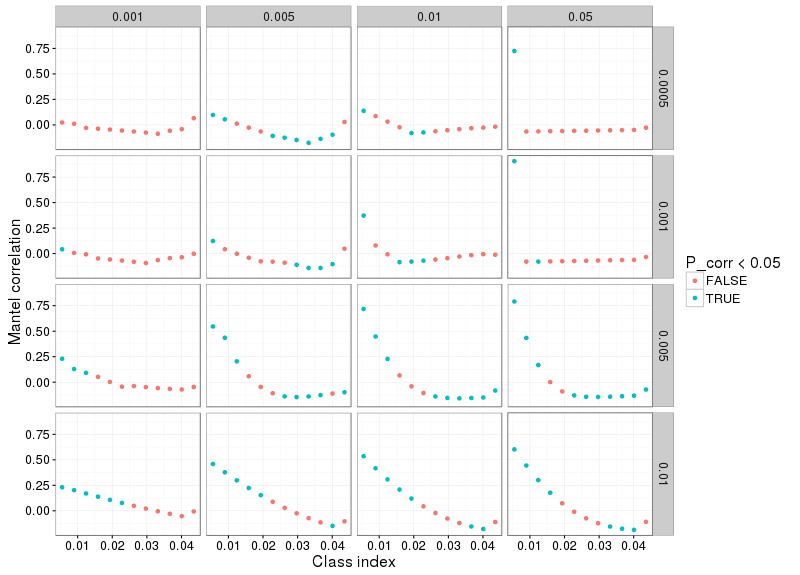

In [67]:
%%R -w 800 -h 575
df.d.s = df.d %>%
    filter(! is.na(Mantel.corr)) %>%
    ungroup() %>%
    mutate(significant = ifelse(Pr.corr <= 0.05, TRUE, FALSE))


ggplot(df.d.s, aes(class.index, Mantel.corr, color=significant)) +
    geom_point() +
    scale_color_discrete('P_corr < 0.05') +
    labs(x='Class index', y='Mantel correlation') +
    facet_grid(W ~ L) +
    theme_bw() +
    theme( 
        text = element_text(size=16)
    ) 

In [68]:
%%R -w 750 -h 600
# pairwise correlations for each dataset
df.d.bin = df.d %>%
    group_by(BD_bin = ntile(class.index, 12)) %>%
    unite(dataset, W, L, sep=':', remove=FALSE)

df.d.bin %>% head

Source: local data frame [6 x 9]
Groups: BD_bin [3]

       dataset      W     L class.index n.dist Mantel.corr    Pr Pr.corr BD_bin
         (chr)  (dbl) (dbl)       (dbl)  (dbl)       (dbl) (dbl)   (dbl)  (int)
1 0.0005:0.001 0.0005 0.001 0.005501721     46  0.02426468 0.056   0.056      1
2 0.0005:0.001 0.0005 0.001 0.008959946     44  0.01203201 0.390   0.390      1
3 0.0005:0.001 0.0005 0.001 0.012418170     42 -0.02861663 0.271   0.542      2
4 0.0005:0.001 0.0005 0.001 0.015876395     40 -0.03687200 0.205   0.615      2
5 0.0005:0.001 0.0005 0.001 0.019334620     38 -0.04554459 0.127   0.508      3
6 0.0005:0.001 0.0005 0.001 0.022792844     36 -0.05468814 0.077   0.385      3


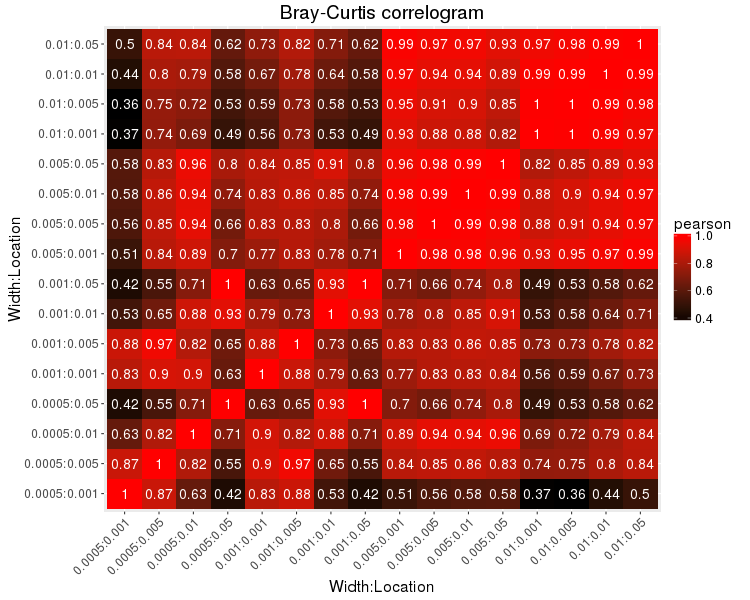

In [69]:
%%R -w 750 -h 600
# pairwise correlations for each dataset
df.d.bin = df.d %>%
    filter(! is.na(Mantel.corr)) %>%
    group_by(BD_bin = ntile(class.index, 12)) %>%
    unite(dataset, W, L, sep=':', remove=FALSE) %>%
    as.data.frame


calc.pearson = function(x){
    ret = cor(x[,'Mantel.corr.x'], x[,'Mantel.corr.y'], method='pearson')[1,1]
    return(ret)
}
as.num = function(x) x %>% as.character %>% as.numeric
 

df.d.corr = inner_join(df.d.bin, df.d.bin, c('BD_bin' = 'BD_bin')) %>%
    group_by(dataset.x, dataset.y) %>%
    nest() %>%
    mutate(model = purrr::map(data, calc.pearson)) %>%
    unnest(pearson = model %>% purrr::map(function(x) x)) %>%
    ungroup() %>%
    select(-data, -model) %>%
    mutate(pearson_txt = round(pearson, 2))
        
 # plotting
lab = 'Width:Location'        
ggplot(df.d.corr, aes(dataset.x, dataset.y, fill=pearson)) +
    geom_tile() +
    geom_text(aes(label=pearson_txt), color='white', size=5) +
    scale_fill_gradient(low='black', high='red') +
    labs(x=lab, y=lab, title='Bray-Curtis correlogram') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    ) 

# Correlograms: Jaccard

In [70]:
%%R
# running
df.d = df %>%
    ungroup() %>%
    group_by(W, L) %>%
    nest() %>%
    mutate(dist.bray = lapply(data, vegdist.by, method='jaccard'),
           dist.BD = lapply(data, BD.diffs),
           mantel.corr = m.corr(dist.bray, dist.BD, n.class=24)) %>%
    select(W, L, mantel.corr) %>%
    unnest(mantel.corr %>% purrr::map(function(x) x)) 
df.d %>% head

Source: local data frame [6 x 7]

       W     L class.index n.dist Mantel.corr    Pr Pr.corr
   (dbl) (dbl)       (dbl)  (dbl)       (dbl) (dbl)   (dbl)
1 0.0005 0.001 0.005501721     46  0.03340746 0.054   0.054
2 0.0005 0.001 0.008959946     44  0.01079532 0.358   0.358
3 0.0005 0.001 0.012418170     42 -0.02995485 0.316   0.632
4 0.0005 0.001 0.015876395     40 -0.03838491 0.190   0.570
5 0.0005 0.001 0.019334620     38 -0.04724158 0.141   0.564
6 0.0005 0.001 0.022792844     36 -0.05657980 0.071   0.355


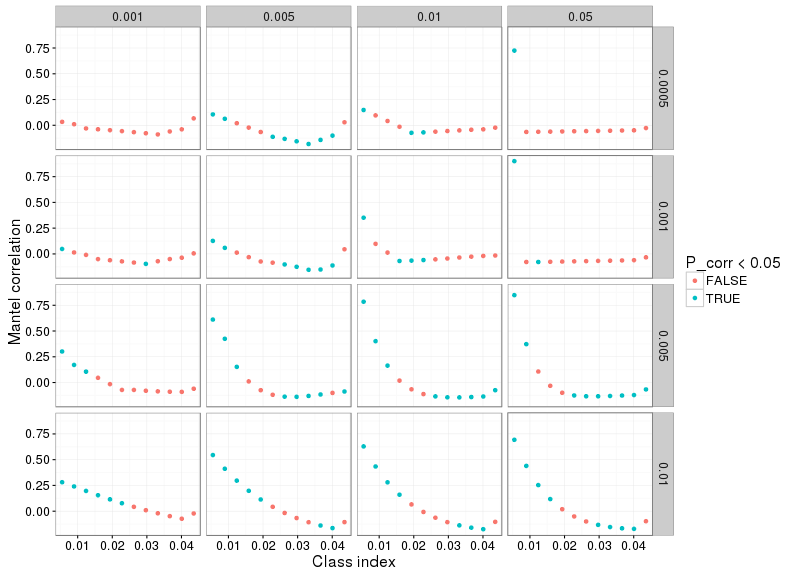

In [71]:
%%R -w 800 -h 575
df.d.s = df.d %>%
    filter(! is.na(Mantel.corr)) %>%
    ungroup() %>%
    mutate(significant = ifelse(Pr.corr <= 0.05, TRUE, FALSE))


ggplot(df.d.s, aes(class.index, Mantel.corr, color=significant)) +
    geom_point() +
    scale_color_discrete('P_corr < 0.05') +
    labs(x='Class index', y='Mantel correlation') +
    facet_grid(W ~ L) +
    theme_bw() +
    theme( 
        text = element_text(size=16)
    ) 

In [72]:
%%R -w 750 -h 600
# pairwise correlations for each dataset
df.d.bin = df.d %>%
    group_by(BD_bin = ntile(class.index, 12)) %>%
    unite(dataset, W, L, sep=':', remove=FALSE)

df.d.bin %>% head

Source: local data frame [6 x 9]
Groups: BD_bin [3]

       dataset      W     L class.index n.dist Mantel.corr    Pr Pr.corr BD_bin
         (chr)  (dbl) (dbl)       (dbl)  (dbl)       (dbl) (dbl)   (dbl)  (int)
1 0.0005:0.001 0.0005 0.001 0.005501721     46  0.03340746 0.054   0.054      1
2 0.0005:0.001 0.0005 0.001 0.008959946     44  0.01079532 0.358   0.358      1
3 0.0005:0.001 0.0005 0.001 0.012418170     42 -0.02995485 0.316   0.632      2
4 0.0005:0.001 0.0005 0.001 0.015876395     40 -0.03838491 0.190   0.570      2
5 0.0005:0.001 0.0005 0.001 0.019334620     38 -0.04724158 0.141   0.564      3
6 0.0005:0.001 0.0005 0.001 0.022792844     36 -0.05657980 0.071   0.355      3


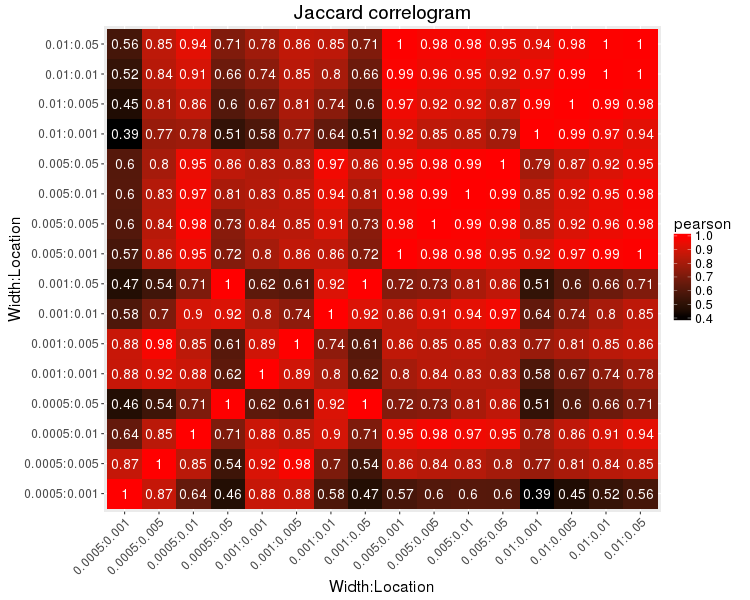

In [74]:
%%R -w 750 -h 600
# pairwise correlations for each dataset
df.d.bin = df.d %>%
    filter(! is.na(Mantel.corr)) %>%
    group_by(BD_bin = ntile(class.index, 12)) %>%
    unite(dataset, W, L, sep=':', remove=FALSE) %>%
    as.data.frame


calc.pearson = function(x){
    ret = cor(x[,'Mantel.corr.x'], x[,'Mantel.corr.y'], method='pearson')[1,1]
    return(ret)
}
as.num = function(x) x %>% as.character %>% as.numeric
 

df.d.corr = inner_join(df.d.bin, df.d.bin, c('BD_bin' = 'BD_bin')) %>%
    group_by(dataset.x, dataset.y) %>%
    nest() %>%
    mutate(model = purrr::map(data, calc.pearson)) %>%
    unnest(pearson = model %>% purrr::map(function(x) x)) %>%
    ungroup() %>%
    select(-data, -model) %>%
    mutate(pearson_txt = round(pearson, 2))
        
 # plotting
lab = 'Width:Location'        
ggplot(df.d.corr, aes(dataset.x, dataset.y, fill=pearson)) +
    geom_tile() +
    geom_text(aes(label=pearson_txt), color='white', size=5) +
    scale_fill_gradient(low='black', high='red') +
    labs(x=lab, y=lab, title='Jaccard correlogram') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    ) 

***
***